# Save FPL API endpoints

Purpose of notebook:

1. Save key FPL API endpoints as JSON so they can be used for future prototyping or for mock API endpoints in testing
2. Find way of getting % chance of playing next round so no longer have to overwrite manually
3. Find way of getting latest price for team selection

## Set-up

In [45]:
import os
import json

import pandas as pd
import numpy as np

In [2]:
# URL to API containing player characteristics data
BOOTSTRAP_STATIC_URL = "https://fantasy.premierleague.com/api/bootstrap-static/"

# URL to API containing player gameweek and upcoming fixtures data
ELEMENT_SUMMARY_URL = "https://fantasy.premierleague.com/api/element-summary/{}/"

In [3]:
os.chdir('../..')

In [4]:
from src.data.live_season_data import _get_fpl_json

## Save key FPL API endpoints as JSON so they can be used for future prototyping or for mock API endpoints in testing

### 1. BOOTSTRAP_STATIC_URL

In [5]:
bootstrap_static_url_output = _get_fpl_json(BOOTSTRAP_STATIC_URL)

In [6]:
bootstrap_static_url_output.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [7]:
with open('data/official_fpl_api_endpoint_examples/BOOTSTRAP_STATIC_URL_season_4_previous_gw_37.json', 'w') as fp:
    json.dump(bootstrap_static_url_output, fp)

In [8]:
# Load JSON
# with open('data/official_fpl_api_endpoint_examples/BOOTSTRAP_STATIC_URL_season_4_previous_gw_37.json') as json_file:
#     test = json.load(json_file)

### Explore endpoint

In [10]:
bootstrap_static_url_output_df = pd.json_normalize(bootstrap_static_url_output, 'elements')

In [12]:
bootstrap_static_url_output_df.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type
0,25.0,100.0,69140,0,0,-4,4,0,2,0.7,...,155.0,47.9,251,98,348,120,231,58,306,102
1,100.0,100.0,98745,0,0,-3,3,0,2,2.9,...,103.0,37.0,315,122,299,93,272,79,336,119
2,100.0,100.0,111457,0,0,-3,3,0,2,3.1,...,79.0,51.2,265,106,216,53,305,98,292,96
3,100.0,100.0,154043,0,0,-5,5,1,2,0.9,...,37.0,47.3,245,97,227,57,364,133,309,104
4,100.0,100.0,39476,0,0,-2,2,1,2,0.5,...,110.0,58.5,162,60,363,128,264,75,268,86


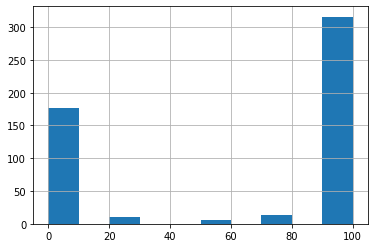

In [11]:
bootstrap_static_url_output_df['chance_of_playing_next_round'].hist()

Utilise:

- `chance_of_playing_next_round`: Scale predictions accordingly
- `chance_of_playing_this_round`: Look's like this might just be the `chance_of_playing_next_round` from the previous gameweek
- `form`: Useful but unfortunately don't have by gameweek - should start collecting!

### 2. ELEMENT_SUMMARY_URL

`ELEMENT_SUMMARY_URL` is a separate endpoint for each player. Players can be identified by their player ID

In [14]:
salah_id = bootstrap_static_url_output_df[bootstrap_static_url_output_df['web_name'] == 'Salah']['id'].item()
salah_id

191

In [15]:
salah_element_summary_url = _get_fpl_json(ELEMENT_SUMMARY_URL.format(salah_id))

In [16]:
salah_element_summary_url.keys()

dict_keys(['fixtures', 'history', 'history_past'])

In [17]:
salah_element_summary_url_history_df = pd.json_normalize(salah_element_summary_url['history'])
print(salah_element_summary_url_history_df.shape)
salah_element_summary_url_history_df.head()

(37, 31)


,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,...,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,191,1,14,12,True,2019-08-09T19:00:00Z,4,1,1,90,...,40,54.8,39.7,39.0,13.4,125,0,2375465,0,0
1,191,19,16,3,False,2019-08-17T14:00:00Z,1,2,2,78,...,0,2.4,11.8,29.0,4.3,125,114282,2778082,156910,42628
2,191,24,1,15,True,2019-08-24T16:30:00Z,3,1,3,90,...,43,71.2,16.6,67.0,15.5,125,-351541,2444065,47097,398638
3,191,32,5,6,False,2019-08-31T16:30:00Z,0,3,4,90,...,15,27.0,38.4,58.0,12.3,125,243530,2810462,291554,48024
4,191,44,13,9,True,2019-09-14T11:30:00Z,3,1,5,90,...,34,44.6,41.8,73.0,15.9,125,31898,2874525,124574,92676


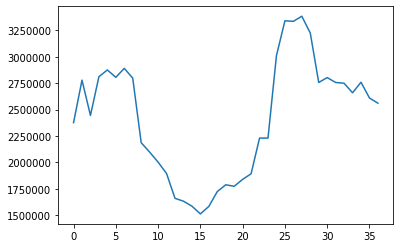

In [18]:
salah_element_summary_url_history_df['selected'].plot()

Save endpoints for 5 selected players and 5 randomly selected IDs

In [52]:
SELECTED_PLAYERS = ['çaglar_söyüncü', 'virgil_van dijk', 'mohamed_salah', 'jamie_vardy', 'mathew_ryan']

In [53]:
bootstrap_static_url_output_df['name'] = bootstrap_static_url_output_df['first_name'] + '_' + bootstrap_static_url_output_df['second_name']
bootstrap_static_url_output_df['name'] = bootstrap_static_url_output_df['name'].str.lower()

In [54]:
np.random.seed(44)
RANDOM_PLAYERS = list(
    bootstrap_static_url_output_df['name'].sample(n=5)
)
PLAYER_LIST = SELECTED_PLAYERS + RANDOM_PLAYERS
PLAYER_LIST

['çaglar_söyüncü',
 'virgil_van dijk',
 'mohamed_salah',
 'jamie_vardy',
 'mathew_ryan',
 'james_garner',
 'kepa_arrizabalaga',
 'ben_johnson',
 'jack_cork',
 'patrick_cutrone']

In [55]:
for player in PLAYER_LIST:
    player_id = bootstrap_static_url_output_df[bootstrap_static_url_output_df['name'] == player]['id'].item()

    player_element_summary_url = _get_fpl_json(ELEMENT_SUMMARY_URL.format(player_id))

    formatted_name = player.replace(' ', '_')
    with open(f'data/official_fpl_api_endpoint_examples/ELEMENT_SUMMARY_URL_season_4_previous_gw_37_{formatted_name}_id_{player_id}.json', 'w') as fp:
        json.dump(player_element_summary_url, fp)

## Find way of getting % chance of playing next round so no longer have to overwrite manually
## Find way of getting latest price for team selection

In [72]:
player_data_json = _get_fpl_json(BOOTSTRAP_STATIC_URL)
players_raw = pd.json_normalize(player_data_json, 'elements')

In [73]:
print(players_raw.shape)
players_raw.head()

(665, 61)


,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type
0,25.0,100.0,69140,0,0,-4,4,0,2,0.7,3.1,0,Shkodran,2.1,1,False,Hamstring injury - 25% chance of playing,2020-07-18T22:30:20.553834Z,51,69140.jpg,2.9,Mustafi,0.4,False,None,d,1,3,43,24990,118,46398,832,0.4,8.4,Mustafi,1205,0,2,4,17,0,0,0,2,0,0,2,242,277.2,45.5,155.0,47.9,251,98,348,120,231,58,306,102
1,100.0,100.0,98745,0,0,-3,3,0,2,2.9,3.4,0,Héctor,2.4,2,False,,2019-12-09T20:00:21.228098Z,52,98745.jpg,2.9,Bellerín,1.0,False,None,a,1,3,44,204565,2178,156990,1965,0.5,8.5,Bellerín,1156,1,0,4,18,0,0,0,2,0,0,4,204,187.8,76.9,103.0,37.0,315,122,299,93,272,79,336,119
2,100.0,100.0,111457,0,0,-3,3,0,2,3.1,3.6,1,Sead,2.6,3,False,,2020-02-23T18:30:13.672943Z,52,111457.jpg,2.2,Kolasinac,0.5,False,None,a,1,3,54,64236,543,133935,241,0.5,10.4,Kolasinac,1661,0,2,4,25,0,0,0,4,0,0,1,325,263.8,172.1,79.0,51.2,265,106,216,53,305,98,292,96
3,100.0,100.0,154043,0,0,-5,5,1,2,0.9,1.4,0,Ainsley,0.4,4,False,,2019-09-22T18:00:10.824841Z,45,154043.jpg,2.1,Maitland-Niles,2.2,False,None,a,1,3,40,610021,782,652853,520,0.1,8.9,Maitland-Niles,1292,0,2,3,20,0,0,0,4,1,0,3,229,282.6,159.5,37.0,47.3,245,97,227,57,364,133,309,104
4,100.0,100.0,39476,0,0,-2,2,1,2,0.5,1.0,0,Sokratis,0.0,5,False,,2020-06-18T18:00:15.974146Z,48,39476.jpg,3.0,Papastathopoulos,1.3,False,None,a,1,3,57,181877,308,230866,421,0.0,11.9,Sokratis,1696,2,0,4,25,0,0,0,6,0,0,5,305,436.2,36.8,110.0,58.5,162,60,363,128,264,75,268,86


In [74]:
players_raw['name'] = players_raw['first_name'] + '_' + players_raw['second_name']
players_raw['name'] = players_raw['name'].str.lower()

In [75]:
players_raw['chance_of_playing_next_round'].fillna(100, inplace=True)

In [76]:
players_raw['now_cost'] /= 10

In [77]:
players_raw['chance_of_playing_next_round'] /= 100

In [79]:
players_raw['chance_of_playing_next_round'].value_counts()

1.00    458
0.00    176
0.75     14
0.25     11
0.50      6
Name: chance_of_playing_next_round, dtype: int64

In [80]:
players_raw[['name', 'now_cost', 'chance_of_playing_next_round']]

,name,now_cost,chance_of_playing_next_round
0,shkodran_mustafi,5.1,0.25
1,héctor_bellerín,5.2,1.00
2,sead_kolasinac,5.2,1.00
3,ainsley_maitland-niles,4.5,1.00
4,sokratis_papastathopoulos,4.8,1.00
...,...,...,...
660,oskar_buur,4.0,1.00
661,ryan_giles,3.9,0.00
662,bruno andré_cavaco jordao,4.5,1.00
663,daniel_castelo podence,4.9,1.00


In [83]:
players_raw[players_raw['chance_of_playing_next_round'] == 0].sample(n=10)[['first_name', 'second_name']]

,first_name,second_name
448,Ralf,Fahrmann
304,Simon,Mignolet
501,Sam,Gallagher
251,Lewis,Gibson
656,Bernard,Ashley-Seal
52,Tom,Heaton
598,Pablo,Zabaleta
205,Christian,Benteke
645,Will,Norris
455,Ondrej,Duda


Check that merge onto predictions is successful

In [24]:
past_predictions = pd.read_parquet('data/gw_predictions/gw30_v4_lstm_player_predictions.parquet')
print(past_predictions.shape)
past_predictions.head()

(616, 14)


,name,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,position_DEF,position_FWD,position_GK,position_MID,team_name,next_match_value,sum,rank
0,mohamed_salah,6.430682,6.186661,6.201383,6.094654,6.116822,0,0,0,1,Liverpool,12.7,31.030201,1
1,kevin_de bruyne,5.630775,5.416529,5.425628,5.323471,5.339586,0,0,0,1,Manchester City,10.6,27.135989,2
2,sadio_mané,5.348968,5.143655,5.148658,5.047873,5.060748,0,0,0,1,Liverpool,12.4,25.749901,3
3,trent_alexander-arnold,4.674833,4.492590,4.492147,4.394203,4.401753,1,0,0,0,Liverpool,7.8,22.455527,4
4,sergio_agüero,4.508854,4.334094,4.333154,4.236525,4.243055,0,1,0,0,Manchester City,11.9,21.655682,5
